In [1]:
import matplotlib as mpl
params = {'axes.spines.right': False,
          'axes.spines.top': False,
          'legend.fontsize': 12,
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'pdf.fonttype': 42,
          'ps.fonttype': 42}
mpl.rcParams.update(params)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import nems.db as nd
from nems_lbhb.baphy_experiment import BAPHYExperiment
from nems.utils import smooth
from nems_lbhb import plots as nplt
from nems.xform_helper import load_model_xform

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-11-13 132215.log


In [2]:
def get_rec(parmfile, cellid, rasterfs=1000, pupil=False):
    e = BAPHYExperiment(parmfile=parmfile, cellid=cellid)
    
    #t = cellid.split("-")
    #e.channels_to_load = [int(t[1])]
    #e.units_to_load = [int(t[2])]

    options={'resp': 1, 'rasterfs': rasterfs, 'pupil': pupil}
    
    rec = e.get_recording(**options)
    return rec

In [3]:
waveform_labels = pd.read_csv('phototag_waveform_labels.csv', index_col=0)


# PSTH analysis

Pick a run class

In [4]:
runclass='TOR'
rasterfs=100

runclass='CPN'
rasterfs=500

# runclass='FTC'
#rasterfs=500

sql="select sCellFile.*,gSingleCell.siteid,gSingleCell.phototag from gSingleCell INNER JOIN sCellFile ON gSingleCell.id=sCellFile.singleid" +\
   " INNER JOIN gRunClass on gRunClass.id=sCellFile.runclassid" +\
   f" WHERE gRunClass.name='{runclass}' AND not(isnull(phototag))"
d=nd.pd_query(sql)
d['parmfile']=d['stimpath']+d['stimfile']
print(len(d))
d.groupby('phototag').count()['cellid']

[numexpr.utils INFO] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[numexpr.utils INFO] NumExpr defaulting to 8 threads.


447


phototag
a     27
n    218
s    202
Name: cellid, dtype: int64

In [5]:
d['parmfile'].unique()

array(['/auto/data/daq/Teonancatl/TNC014/TNC014a09_p_CPN.m',
       '/auto/data/daq/Teonancatl/TNC016/TNC016a11_p_CPN.m',
       '/auto/data/daq/Teonancatl/TNC017/TNC017a11_p_CPN.m',
       '/auto/data/daq/Teonancatl/TNC015/TNC015a11_p_CPN.m',
       '/auto/data/daq/Teonancatl/TNC013/TNC013a09_p_CPN.m',
       '/auto/data/daq/Teonancatl/TNC011/TNC011a06_p_CPN.m',
       '/auto/data/daq/Teonancatl/TNC010/TNC010a11_p_CPN.m',
       '/auto/data/daq/Teonancatl/TNC009/TNC009a14_p_CPN.m',
       '/auto/data/daq/Teonancatl/TNC008/TNC008a09_p_CPN.m',
       '/auto/data/daq/Teonancatl/TNC006/TNC006a08_p_CPN.m',
       '/auto/data/daq/Teonancatl/TNC018/TNC018a12_p_CPN.m'], dtype=object)

In [6]:
parmfile="/auto/data/daq/Teonancatl/TNC014/TNC014a09_p_CPN.m"
cellid="TNC014a-01-2"

e = BAPHYExperiment(parmfile=parmfile, cellid=cellid)
options={'resp': 1, 'rasterfs': rasterfs,'pupil': True}    
rec = e.get_recording(**options)

[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC014a/TNC014a_e41af539df4bf7394fb7a19cee70b2d6c1299f49.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found


Load all A cells (sort of slow)

In [7]:
psth_a=[]
error_cellid=[]
for i, r in d.loc[d.phototag=='a'].iterrows():
    try:
        rec = get_rec(r.parmfile, r.cellid, rasterfs=rasterfs)
        rec['resp']=rec['resp'].rasterize()
        r=rec['resp'].extract_epoch('REFERENCE')
        psth_a.append(smooth(r.mean(axis=0)[0,:],5))
    except:
        error_cellid.append(r.cellid)


[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC014a/TNC014a_c603315a1131a71e400fba1eb6f9a23722ce5a2c.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC014a/TNC014a_963af78fd72e133caf2da6e7d1fb1c827f2cfa52.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC015a/TNC015a_aeae10d0a55c61136db4a9aa1958ea356fc775ab.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC015a/TNC015a_dd437ef8728d894ccbba333d1d3a774192bec484.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC015a/TNC015a_bc686e5ade9d8b8867de775df2db44d59b54c158.tgz
[n

Load all S cells (slower)

In [8]:
psth_s=[]
for i, r in d.loc[d.phototag=='s'].iterrows():
    try:
        rec = get_rec(r.parmfile, r.cellid, rasterfs=rasterfs)
        rec['resp']=rec['resp'].rasterize()
        r=rec['resp'].extract_epoch('REFERENCE')
        psth_s.append(smooth(r.mean(axis=0)[0,:],5))
    except:
        error_cellid.append(r.cellid)

[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC014a/TNC014a_5e93cbc3594d815713cb8d0839de04a915c3f911.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC016a/TNC016a_e97481e2424336a91227f0bd8f87a6e2c7bdcefe.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC016a/TNC016a_a61ca84c05b48dc35aea9e05cf780d1d1833871a.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC016a/TNC016a_cba999a3a5bf9cee688ec3f22847503185bf1d8a.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC016a/TNC016a_be69b47e5b8d82e2debc8846ad25128358898f71.tgz
[n

In [9]:
print('error cellids:', error_cellid)

error cellids: []


140.0 131.0


Text(0, 0.5, 'fraction units')

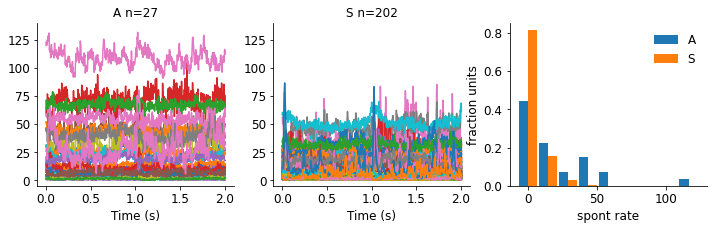

In [50]:
f,ax = plt.subplots(1,3,figsize=(12,3))

re=np.stack(psth_a) * rasterfs
ri=np.stack(psth_s) * rasterfs

ymax=np.ceil(np.max([re.max(), ri.max()])/10)*10
y0max=np.ceil(np.max([re[:,:50].max(), ri[:,:50].max()]))
print(ymax, y0max)

tt=np.arange(re.shape[1])/rasterfs
ax[0].plot(tt,re.T);
ax[0].set_title(f'A n={re.shape[0]}')
ax[0].set_ylim([-5, ymax])
ax[0].set_xlabel('Time (s)')

ax[1].plot(tt,ri.T)
ax[1].set_title(f'S n={ri.shape[0]}');
ax[1].set_ylim([-5, ymax])
ax[1].set_xlabel('Time (s)')

bins=np.linspace(0,y0max,10)
n0,b0 = np.histogram(re[:,:50].mean(axis=1), bins=bins)
n1,b1 = np.histogram(ri[:,:50].mean(axis=1), bins=bins)
n0= n0/n0.sum()
n1=n1/n1.sum()
w=(b0[1]-b0[0])/2.2
ax[2].bar(b0[:-1]-w/2,n0,width=w,label='A');
ax[2].bar(b0[:-1]+w/2,n1,width=w,label='S');
ax[2].legend(frameon=False);
ax[2].set_xlabel('spont rate')
ax[2].set_ylabel('fraction units')
#f.suptitle(runclass)

# resp vs. pupil examples

In [4]:
# other S cells. potential examples
cellid_S="TNC016a-42-1"
cellid_S="TNC016a-45-1"
cellid_S="TNC016a-38-2"

cellid_S="TNC016a-30-1"
cellid_A="TNC016a-60-1"

runclass="CPN"
rasterfs=10  # or whatever rate you want

### EXAMPLE A CELL

In [273]:
cellid=cellid_A

df = nd.get_cell_files(cellid=cellid, runclass=runclass)
parmfile=df.loc[0,'stimpath']+df.loc[0,'stimfile']

e = BAPHYExperiment(parmfile=parmfile, cellid=cellid)
options={'resp': 1, 'rasterfs': rasterfs, 'pupil': True}    
rec = e.get_recording(**options)

[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC016a/TNC016a_47475e422d2041b868682c8fa7200c5ffd7c0fff.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found


Text(0.5, 0, 'Experiment time (s)')

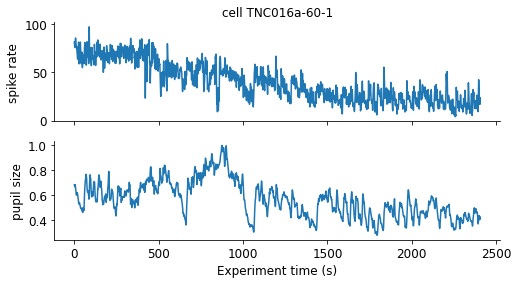

In [274]:
r=rec['resp'].rasterize().extract_epoch('REFERENCE')
resp=smooth(r.flatten(),50) * rasterfs

p=rec['pupil'].extract_epoch('REFERENCE')
pup = smooth(rec['pupil'].extract_epoch('REFERENCE').flatten(),50)
pup = pup / pup.max()

tt=np.arange(len(resp))/rasterfs

f,ax = plt.subplots(2,1,figsize=(8,4), sharex=True)
ax[0].plot(tt,resp)
ax[1].plot(tt,pup)
ax[0].set_title(f"cell {cellid}")
ax[0].set_ylabel("spike rate")
ax[1].set_ylabel("pupil size")
ax[1].set_xlabel("Experiment time (s)")

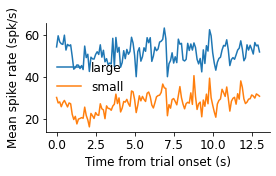

In [275]:
r=rec['resp'].rasterize().extract_epoch('TRIAL')
p=rec['pupil'].extract_epoch('TRIAL')
p=p.mean(axis=2)[:,0]
p_hi = p>np.median(p)
p_lo = p<=np.median(p)

psth_hi=r[p_hi,0,:].mean(axis=0) * rasterfs
psth_lo=r[p_lo,0,:].mean(axis=0) * rasterfs
tt=np.arange(len(psth_hi))/rasterfs

f,ax = plt.subplots(1,1,figsize=(4,2), sharex=True)
ax.plot(tt,psth_hi,label='large')
ax.plot(tt,psth_lo,label='small')
ax.legend(frameon=False)
ax.set_xlabel("Time from trial onset (s)")
ax.set_ylabel("Mean spike rate (spk/s)");

### EXAMPLE S CELL

In [276]:
cellid=cellid_S

df = nd.get_cell_files(cellid=cellid, runclass=runclass)
parmfile=df.loc[0,'stimpath']+df.loc[0,'stimfile']

e = BAPHYExperiment(parmfile=parmfile, cellid=cellid)
options={'resp': 1, 'rasterfs': rasterfs, 'pupil': True}    
rec = e.get_recording(**options)

[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC016a/TNC016a_67bd14ac8bc62dbda913a4ab3ac88820d2570a2d.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found


Text(0.5, 0, 'Experiment time (s)')

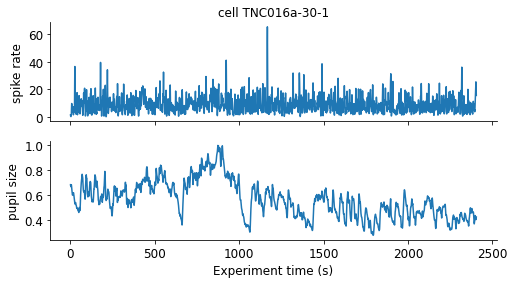

In [277]:
r=rec['resp'].rasterize().extract_epoch('REFERENCE')
resp=smooth(r.flatten(),50) * rasterfs

p=rec['pupil'].extract_epoch('REFERENCE')
pup = smooth(rec['pupil'].extract_epoch('REFERENCE').flatten(),50)
pup = pup / pup.max()

tt=np.arange(len(resp))/rasterfs

f,ax = plt.subplots(2,1,figsize=(8,4), sharex=True)
ax[0].plot(tt,resp)
ax[1].plot(tt,pup)
ax[0].set_title(f"cell {cellid}")
ax[0].set_ylabel("spike rate")
ax[1].set_ylabel("pupil size")
ax[1].set_xlabel("Experiment time (s)")

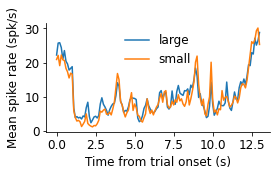

In [279]:
r=rec['resp'].rasterize().extract_epoch('TRIAL')
p=rec['pupil'].extract_epoch('TRIAL')
p=p.mean(axis=2)[:,0]
p_hi = p>np.median(p)
p_lo = p<=np.median(p)

psth_hi=r[p_hi,0,:].mean(axis=0) * rasterfs
psth_lo=r[p_lo,0,:].mean(axis=0) * rasterfs
tt=np.arange(len(psth_hi))/rasterfs

f,ax = plt.subplots(1,1,figsize=(4,2), sharex=True)
ax.plot(tt,psth_hi,label='large')
ax.plot(tt,psth_lo,label='small')
ax.legend(frameon=False)
ax.set_xlabel("Time from trial onset (s)")
ax.set_ylabel("Mean spike rate (spk/s)");

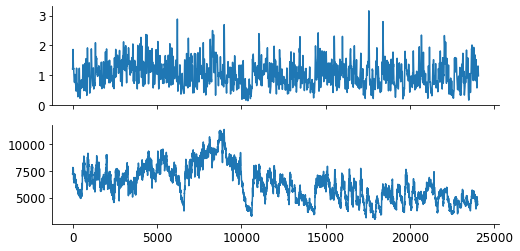

# pupil pred

In [51]:
runclass='NAT'
rasterfs=10
runclass='CPN'
rasterfs = 10

sql="select sCellFile.*,gSingleCell.siteid,gSingleCell.phototag from gSingleCell INNER JOIN sCellFile ON gSingleCell.id=sCellFile.singleid" +\
   " INNER JOIN gRunClass on gRunClass.id=sCellFile.runclassid" +\
   f" WHERE gRunClass.name='{runclass}' AND not(isnull(phototag))"
d=nd.pd_query(sql)
d['parmfile']=d['stimpath']+d['stimfile']

print(d.shape)

d=d[['cellid','phototag']].drop_duplicates()
d=d.set_index('cellid')

print(d.shape)


(447, 43)
(447, 1)


In [52]:
if runclass=='CPN':
    #modelnames = ['psth.fs20.pup-ld-st.pup0-epcpn.seq-hrc-psthfr_sdexp2.S_jk.nf20-basic',
    #              'psth.fs20.pup-ld-st.pup-epcpn.seq-hrc-psthfr_sdexp2.S_jk.nf20-basic']
    modelnames = ['psth.fs{rasterfs}.pup-ld-st.pup0-epcpn-hrc-psthfr_sdexp2.S_jk.nf20-basic',
                  'psth.fs{rasterfs}.pup-ld-st.pup-epcpn-hrc-psthfr_sdexp2.S_jk.nf20-basic']
    modelnames = [f'psth.fs{rasterfs}.pup-ld-st.pup0-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic',
                  f'psth.fs{rasterfs}.pup-ld-st.pup-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic']
    batch=331
else:
    batch=322
    modelnames = [f'psth.fs{rasterfs}.pup-ld-st.pup0-hrc-psthfr_stategain.S_jk.nf20-basic',
                  f'psth.fs{rasterfs}.pup-ld-st.pup-hrc-psthfr_stategain.S_jk.nf20-basic',
                ]

In [78]:
dpred = nd.batch_comp(batch=batch,modelnames=modelnames)
dpred = dpred.merge(d['phototag'],how='inner',left_index=True, right_index=True)
dpred['siteid'] = dpred.index
dpred['siteid']=dpred['siteid'].apply(nd.get_siteid)
dpred['diff'] = dpred[modelnames[1]]-dpred[modelnames[0]]

dpred=dpred.merge(waveform_labels[['cellid','wshape']],how='left',left_index=True, right_on='cellid').set_index('cellid')
#dpred['wshape']=dpred['wshape'].fillna("?")
dpred['pw'] = dpred['phototag']+" "+dpred['wshape']

dmean=dpred.groupby('phototag').mean()  # .reset_index()
dcount=dpred.groupby('phototag').count()  # .reset_index()
dcount['n']=dcount[modelnames[0]]
dmean=dmean.merge(dcount['n'],how='inner',left_index=True, right_index=True)
dmean['label'] = [f"{i[0].upper()} n={r.n:.0f} delta={r['diff']:.3f}" for i,r in dmean.iterrows()]
dpred=dpred.merge(dmean[['label']],how='inner',left_on='phototag', right_index=True)

dmean=dpred.groupby(['pw']).mean()  # .reset_index()
dcount=dpred.groupby(['pw']).count()  # .reset_index()
dcount['n']=dcount[modelnames[0]]
dmean=dmean.merge(dcount['n'],how='inner',left_index=True, right_index=True)
dmean['label2'] = [f"{i.upper()} n={r.n:.0f} delta={r['diff']:.3f}" for i,r in dmean.iterrows()]
dpred=dpred.merge(dmean[['label2']],how='inner',left_on=['pw'], right_index=True)

dpred['g']=1
dpred['d']=0

In [79]:
dpred.groupby('phototag')[['diff']].count()

,diff
phototag,
a,21
s,157


In [91]:
dpred.loc[(dpred['siteid']=='TNC013a')].sort_values(by='diff')

,psth.fs10.pup-ld-st.pup0-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic,psth.fs10.pup-ld-st.pup-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic,phototag,siteid,diff,wshape,pw,label,label2,g,d
cellid,,,,,,,,,,,
TNC013a-17-1,0.133510,0.140955,a,TNC013a,0.007445,RS,a RS,A n=25 delta=0.041,A RS n=9 delta=0.050,1,0
TNC013a-52-2,0.226129,0.238721,a,TNC013a,0.012592,RS,a RS,A n=25 delta=0.041,A RS n=9 delta=0.050,1,0
TNC013a-42-2,0.400886,0.424397,a,TNC013a,0.023511,NS,a NS,A n=25 delta=0.041,A NS n=12 delta=0.033,1,0
TNC013a-26-1,0.275642,0.301148,a,TNC013a,0.025507,RS,a RS,A n=25 delta=0.041,A RS n=9 delta=0.050,1,0
TNC013a-46-1,0.427347,0.471001,s,TNC013a,0.043655,RS,s RS,S n=170 delta=0.016,S RS n=122 delta=0.015,1,0
TNC013a-15-1,0.228537,0.313076,a,TNC013a,0.084538,NS,a NS,A n=25 delta=0.041,A NS n=12 delta=0.033,1,0
TNC013a-12-2,0.182823,0.272065,a,TNC013a,0.089242,NS,a NS,A n=25 delta=0.041,A NS n=12 delta=0.033,1,0
TNC013a-22-1,0.170966,0.269809,s,TNC013a,0.098844,RS,s RS,S n=170 delta=0.016,S RS n=122 delta=0.015,1,0
TNC013a-31-1,0.146975,0.284605,a,TNC013a,0.137630,RS,a RS,A n=25 delta=0.041,A RS n=9 delta=0.050,1,0


In [72]:
for cellid in dpred.index:
    xf,ctx=load_model_xform(cellid=cellid,modelname=modelnames[1],batch=batch,eval_model=False)
    dpred.loc[cellid,'d']=ctx['modelspec'].phi[0]['d'][0,1]
    dpred.loc[cellid,'g']=ctx['modelspec'].phi[0]['g'][0,1]

[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC006a-07-1/psth.fs10.pup-ld-st.pup-epcpn-hrc-psthfr.stategain.S.jk.nf20-basic.2021-11-06T231125 ...
[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC006a-09-1/psth.fs10.pup-ld-st.pup-epcpn-hrc-psthfr.stategain.S.jk.nf20-basic.2021-11-06T231139 ...
[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC006a-10-1/psth.fs10.pup-ld-st.pup-epcpn-hrc-psthfr.stategain.S.jk.nf20-basic.2021-11-06T231151 ...
[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC006a-11-1/psth.fs10.pup-ld-st.pup-epcpn-hrc-psthfr.stategain.S.jk.nf20-basic.2021-11-06T231204 ...
[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC006a-15-1/psth.fs10.pup-ld-st.pup-epcpn-hrc-psthfr.stategain.S.jk.nf20-basic.2021-11-06T231208 ...
[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/33

In [81]:
dpred.groupby(['pw']).count()

,psth.fs10.pup-ld-st.pup0-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic,psth.fs10.pup-ld-st.pup-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic,phototag,siteid,diff,wshape,label,label2,g,d
pw,,,,,,,,,,
a NS,12,12,12,12,12,12,12,12,12,12
a RS,9,9,9,9,9,9,9,9,9,9
s NS,35,35,35,35,35,35,35,35,35,35
s RS,122,122,122,122,122,122,122,122,122,122


In [82]:
dpred['diff'] = dpred[modelnames[1]]-dpred[modelnames[0]]
dm = dpred.groupby(['siteid','phototag']).mean()
dmc = dpred.groupby(['siteid','phototag']).count()

dm = dm[['diff']].merge(dmc['label'],how='inner',left_index=True, right_index=True)

In [83]:
dmc

psth.fs10.pup-ld-st.pup0-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic  \
siteid  phototag                                                                        
TNC006a a                                                         1                     
TNC008a a                                                         1                     
        s                                                         8                     
TNC009a s                                                         3                     
TNC010a s                                                         2                     
TNC011a s                                                         4                     
TNC013a a                                                         7                     
        s                                                         5                     
TNC014a a                                                         1                     
        s                                                        34                     
TNC015a a                                                         2                     
        s                                                        13                     
TNC016a a                                                         4                     
        s                                                        24                     
TNC017a s                                                        28                     
TNC018a a                                                         5                     
        s                                                        36                     

                  psth.fs10.pup-ld-st.pup-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic  \
siteid  phototag                                                                       
TNC006a a                                                         1                    
TNC008a a                                                         1                    
        s                                                         8                    
TNC009a s                                                         3                    
TNC010a s                                                         2                    
TNC011a s                                                         4                    
TNC013a a                                                         7                    
        s                                                         5                    
TNC014a a                                                         1                    
        s                                                        34                    
TNC015a a                                                         2                    
        s                                                        13                    
TNC016a a                                                         4                    
        s                                                        24                    
TNC017a s                                                        28                    
TNC018a a                                                         5                    
        s                                                        36                    

                  diff  wshape  pw  label  label2   g   d  
siteid  phototag                                           
TNC006a a            1       1   1      1       1   1   1  
TNC008a a            1       1   1      1       1   1   1  
        s            8       8   8      8       8   8   8  
TNC009a s            3       3   3      3       3   3   3  
TNC010a s            2       2   2      2       2   2   2  
TNC011a s            4       4   4      4       4   4   4  
TNC013a a            7       7   7      7       7   7   7  
        s            5       5   5      5       5   5   5  
TNC014a a            1       1   1      1       1   1

#### Summary plots A: pupil contribution to model prediction. B: pupil-dependent dc and gain. Broken down by A vs. S

Text(0.5, 0.98, 'psth.fs10.pup-ld-st.pup-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic')

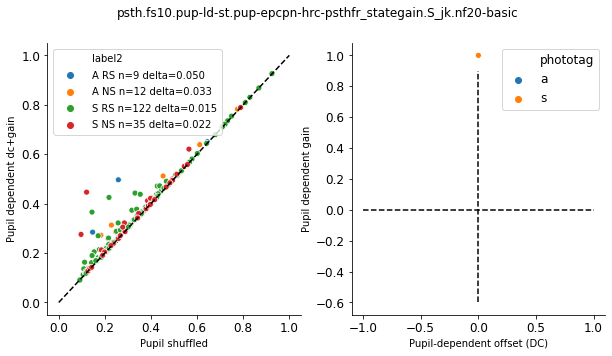

In [85]:
from seaborn import scatterplot, barplot

sa_subset = dpred.loc[(dpred.phototag=='a') | (dpred.phototag=='s')]

f,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot([0.0,1],[0.0,1],'k--')
scatterplot(data=sa_subset, x=modelnames[0], y=modelnames[1], hue='label2', ax=ax[0]);
plt.setp(ax[0].get_legend().get_texts(), fontsize='10'); #, frameon=False)
ax[0].set_xlabel('Pupil shuffled',fontsize=10)
ax[0].set_ylabel('Pupil dependent dc+gain',fontsize=10)

ax[1].plot([-1,1],[0.0,0],'k--')
ax[1].plot([0.0,0],[-0.6,0.9],'k--')
scatterplot(data=sa_subset, x='d', y='g', hue='phototag', ax=ax[1]);
ax[1].set_xlabel('Pupil-dependent offset (DC)',fontsize=10)
ax[1].set_ylabel('Pupil dependent gain',fontsize=10)

f.suptitle(modelnames[1])

### break down by site.

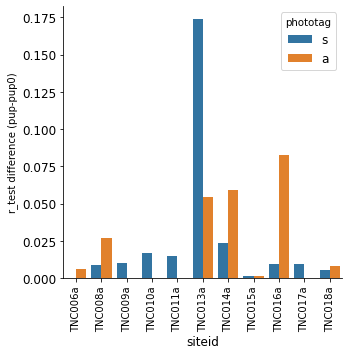

In [89]:
f,ax=plt.subplots(1,1,figsize=(5,5))
barplot(data=dm.reset_index(), x='siteid', y='diff', hue='phototag', ax=ax, hue_order=['s','a'])
plt.setp(ax.get_xticklabels(), fontsize='10', rotation=90); #, frameon=False)
ax.set_ylabel('r_test difference (pup-pup0)',fontsize=10);

In [91]:
dpred.loc[dpred.phototag=='s',['diff','d','g']]

,diff,d,g
cellid,,,
TNC013a-01-2,0.034821,-0.025267,-0.000350
TNC013a-10-1,0.002883,-0.003755,0.000109
TNC013a-12-1,0.003088,-0.011791,0.183123
TNC013a-20-1,0.081789,0.156850,0.612061
TNC013a-22-1,0.013490,0.002717,0.339027
...,...,...,...
TNC015a-22-1,0.000128,0.005313,-0.009555
TNC015a-22-2,-0.000296,-0.005902,-0.041073
TNC015a-30-1,0.000967,-0.019096,-0.022380


In [4]:
    def list_all_recordings():
        print('listing all taggable sites...')
        df = nd.pd_query("SELECT * FROM gSingleCell INNER JOIN sCellFile ON gSingleCell.cellid = sCellFile.cellid" +
                         " WHERE sCellFile.RunClassid = 51 AND sCellFile.cellid LIKE %s",
                         params=("TNC%",))

        # clean up DF
        DF = pd.DataFrame()
        DF['cellid'] = df.cellid.iloc[:, 0]
        DF['siteid'] = df.siteid
        DF['recording'] = df.stimfile.apply(lambda x: x.split('.')[0])
        DF['parmfile'] = df.stimpath + df.stimfile  # full path to parameter file.
        DF['rawid'] = df.rawid.iloc[:, 1]

        recordings = DF.recording.unique()
        DF = DF
        return recordings, DF

    def ready_recording(self, site):
        """
        load a whole recording at a time. Much more efficient than loading individual neurons.
        Uses a site name to define a list of parameters files
        :param site:
        :return:
        """
        print('loading selected site...')

        parmfile, rawid = self.DF.query('recording == @site').loc[:, ('parmfile', 'rawid')].iloc[0, :].tolist()

        self.animal = parmfile.split('/')[4]

        manager = BAPHYExperiment(parmfile=parmfile, rawid=rawid)

        rec = manager.get_recording(recache=self.recache, **self.options)

In [5]:
rec,df=list_all_recordings()

listing all taggable sites...


[numexpr.utils INFO] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[numexpr.utils INFO] NumExpr defaulting to 8 threads.


In [6]:
dfiles = df[['siteid','stimpath','stimfile','rawid']].drop_duplicates().reset_index()
dfiles.loc[dfiles.stimfile=="TNC015a17_p_NON.m"]



KeyError: "['stimpath', 'stimfile'] not in index"

In [7]:
df = nd.pd_query("SELECT sCellFile.*,gSingleCell.siteid FROM gSingleCell INNER JOIN sCellFile ON gSingleCell.cellid = sCellFile.cellid" +
                         " WHERE sCellFile.RunClassid = 51 AND sCellFile.cellid LIKE %s",
                         params=("TNC%",))

dfiles = df[['siteid','stimpath','stimfile','rawid']].drop_duplicates().reset_index()

for i in [32]:  #range(len(dfiles)):
    siteid=dfiles.iloc[i]['siteid']
    stimfile = dfiles.iloc[i]['stimfile']
    parmfile = dfiles.iloc[i]['stimpath']+dfiles.iloc[i]['stimfile']
    rawid = dfiles.iloc[i]['rawid']
    manager = BAPHYExperiment(parmfile=parmfile, rawid=rawid)

    rec = manager.get_recording(rasterfs=1000, resp=True, includeprestim=True)
    rec_cells = rec['resp'].chans
    ff_site = (df.stimfile==stimfile)
    ff_match = (df.cellid.isin(rec_cells)) & ff_site
    ff_nonmatch = (1-df.cellid.isin(rec_cells)) & ff_site
    print(dfiles.iloc[i]['stimfile'], 'N in sCellFile:', (df.stimfile==stimfile).sum(), 
          'N matches in recording:', ff_match.sum())
    if ff_nonmatch.sum()>0:
        print(df.loc[ff_nonmatch,['cellid','stimfile']])

[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC015a/TNC015a_73db9ea8edfc3c6ee0a7cf39c5e05ed5f336cb8c.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found


TNC015a17_p_NON.m N in sCellFile: 26 N matches in recording: 26


In [8]:
rec_cells = rec['resp'].chans
#df.loc[df.siteid==siteid,'cellid'].isin(rec_cells).sum().values[0], (df.siteid==siteid).sum()
rec_cells
#dsite['exists']=dsite['cellid'].isin(rec['resp'].chans)
#dsite
#dsite['cellid'].isin(rec_cells).sum()


['TNC015a-07-2',
 'TNC015a-07-3',
 'TNC015a-10-1',
 'TNC015a-10-4',
 'TNC015a-11-1',
 'TNC015a-11-3',
 'TNC015a-12-1',
 'TNC015a-12-2',
 'TNC015a-14-1',
 'TNC015a-14-2',
 'TNC015a-19-1',
 'TNC015a-19-2',
 'TNC015a-19-4',
 'TNC015a-19-5',
 'TNC015a-20-1',
 'TNC015a-20-3',
 'TNC015a-21-1',
 'TNC015a-21-2',
 'TNC015a-22-1',
 'TNC015a-22-2',
 'TNC015a-22-5',
 'TNC015a-22-6',
 'TNC015a-25-1',
 'TNC015a-25-3',
 'TNC015a-30-1',
 'TNC015a-30-2',
 'TNC015a-30-4',
 'TNC015a-30-5',
 'TNC015a-31-1',
 'TNC015a-31-2',
 'TNC015a-31-5',
 'TNC015a-31-6',
 'TNC015a-32-1',
 'TNC015a-32-3',
 'TNC015a-34-1',
 'TNC015a-34-3',
 'TNC015a-36-1',
 'TNC015a-36-2',
 'TNC015a-36-4',
 'TNC015a-36-5',
 'TNC015a-37-1',
 'TNC015a-37-2',
 'TNC015a-37-6',
 'TNC015a-37-7',
 'TNC015a-39-1',
 'TNC015a-39-2',
 'TNC015a-39-5',
 'TNC015a-39-6',
 'TNC015a-51-1',
 'TNC015a-51-3',
 'TNC015a-52-1',
 'TNC015a-52-2']

Text(0.5, 1.0, 'TNC016a-45-1')

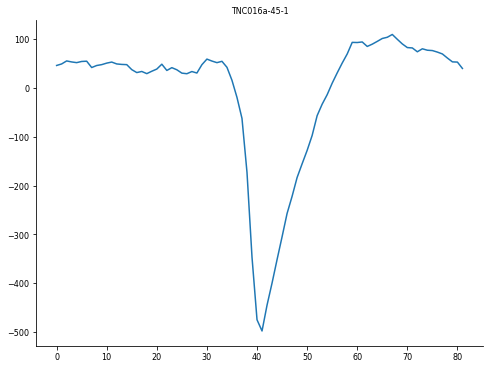

In [28]:
import importlib
import nems_lbhb.baphy_io as io
importlib.reload(io)

cellid="TNC015a-51-3"
cellid="TNC015a-39-6"
cellid="TNC016a-45-1"
eg_waveform = io.get_mean_spike_waveform(cellid, 'Teonancatl', usespkfile=True)
plt.plot(eg_waveform)
plt.title(cellid)

In [21]:
eg_waveform


array([  69.45002562,   67.90160655,   65.61687044,   63.52461417,
         61.54361785,   61.20264568,   64.02044693,   72.9357569 ,
         70.26729798,   64.46378078,   60.20390528,   54.11636214,
         49.68983396,   42.27299666,   38.54452092,   39.80307362,
         46.11731937,   40.73592205,   39.9175464 ,   42.54085968,
         41.35453329,   41.19724452,   46.3776783 ,   38.25452895,
         35.71650207,   35.06231637,   28.9607056 ,   26.39042049,
         32.23023072,   36.60892694,   29.88532277,   25.21825694,
         15.3265953 ,   11.49923301,   -2.39490335,  -16.15685361,
        -43.35762182, -116.59817413, -264.85943661, -466.46229321,
       -595.75758384, -592.2361028 , -532.08859745, -474.08576762,
       -407.61826531, -343.98669505, -278.82161465, -214.27353638,
       -168.23292838, -125.81021649,  -85.55578621,  -43.86998477,
         -7.27312348,   26.00452   ,   55.64269924,   85.28119666,
        105.01982115,  114.79840575,  124.38680541,  134.23489